In [4]:
# Read both events and peaks, then merge
import os, sys, io, time
from os.path import isfile, join
import pandas as pd
import numpy as np

from multiprocessing import Pool
from tqdm import tqdm
from pax.utils import Memoize
from numba import vectorize, guvectorize, int64, int32

class read_n_merge():
    __version__ = '0.0.6'

    def process(self,
                indir_larges2='', indir_peak='', indir_elist='',
                outdir_peak='', outdir_elist='',
                number_file_cap=0, number_cup=1, 
                force_reload=False, process_only = False,
               ):
        # The main function to call (just a personal habbit not to write it as __call__)
        self.indir = dict(larges2 = indir_larges2, peak = indir_peak, elist = indir_elist)
        self.outdir = dict(larges2 = indir_larges2, peak = outdir_peak, elist = outdir_elist)
        self.number_file_cap = number_file_cap; self.number_cup = number_cup; 
        self.force_reload = force_reload; self.process_only = process_only
        
        for outdir in self.outdir.values():
            if not os.path.exists(outdir): os.makedirs(outdir)
        
        # Record all the file in folder, and put a cup on number of files
        file_list = [[f for f in os.listdir(d) if 'pkl' in f] for d in self.indir.values()]
        file_list = list(set(file_list[0]).intersection(file_list[1]).intersection(file_list[2]))
        
        # Limit number of files to read
        if isinstance(self.number_file_cap, int):
            file_list = file_list[:self.number_file_cap]
        else:
            # Back door for hand select files directly
            file_list = self.number_file_cap
        self.file_list = file_list

        # Process with the choice of using multiple cores 
        # cup = cpu but already got used to this typo
        if self.number_cup > 1:
            # Use multithread processing
            with Pool(processes=self.number_cup, maxtasksperchild=50) as pool:
                self.result = list(tqdm(pool.imap_unordered(self._process, file_list, 3), total = len(file_list)))

        else:
            self.result = []
            # Use a loop to process
            with tqdm(total = len(file_list)) as pBar:
                for file in file_list:
                    pBar.update(1)
                    self.result.append(self._process(file))

        self.elist, self.larges2, self.peak, self.errors = zip(*self.result)

        # Concat and return result
        if len(self.elist) != 0: self.elist = pd.concat(self.elist)
        if len(self.peak) != 0: self.peak = pd.concat(self.peak)
        return self.elist, self.peak

    def _process(self, file):
        # Main function acting on individual files
        self._process_list = [self._check_existance,
                              self._read_pickle,
                              self._calculations,
                              self._reduce_columns,
                              self._write,
                             ]
        
        # Initiate result to prevent return none when encounter failure
        ans = [pd.DataFrame() for key in self.outdir.keys()]; error = None;
        rolling_kwarg = dict(file = file)
        
        # Loop over stages of processing
        for proc in self._process_list:
            try:
                rolling_kwarg = (proc(**rolling_kwarg))
            except Exception as error:
                return tuple(ans) + tuple([(proc.__name__, error)])
            if all(rolling_kwarg['flag'].values()):
                if self.process_only:
                    return tuple(ans) + tuple([(proc.__name__, error)])
                else:
                    return tuple([rolling_kwarg['ans'][key] for key in sorted(self.outdir.keys())]) + tuple([error])

    def _check_existance(self, file):
        ans, flag = dict(), dict()

        for key in self.outdir.keys():
            if isfile(join(self.outdir[key], file)):
                flag.update({key:True})
                ans.update({key:pd.read_pickle(join(self.outdir[key], file))})
            else:
                flag.update({key:False})
        return dict(file = file, ans = ans, flag = flag)

    def _read_pickle(self, file, ans, flag):
        for key in ['peak', 'elist']:
            if not flag[key]:
                ans.update({key:pd.read_pickle(join(self.indir[key], file))})
        return dict(file = file, ans = ans, flag = flag)

    def _calculations(self, file, ans, flag):
        @Memoize
        def get_previous_s2_area(event_number):
            if event_number == 0: return [0]
            event_number -= 1
            areas = ans['larges2'].loc[ans['larges2'].event_number == event_number].area.values
            if len(areas) > 0: return areas
            else: return get_previous_s2_area(event_number)

        @Memoize
        def get_previous_s2_time(event_number):
            if event_number == 0: return [0]
            event_number -= 1
            times = ans['larges2'].loc[ans['larges2'].event_number == event_number].hit_time_mean_global.values
            if len(times) > 0: return times
            else: return get_previous_s2_time(event_number)

        for key in ['peak', 'elist']:
            if not flag[key]:
                ans[key]['previous_s2_areas'] = [get_previous_s2_area(n) for n in ans[key].event_number.values]
                ans[key]['previous_s2_times'] = [get_previous_s2_time(n) for n in ans[key].event_number.values]
                ans[key]['previous_largest_s2_area'] = [np.amax(areas) for areas in ans[key].previous_s2_areas.values]
                ans[key]['previous_largest_s2_index'] = [np.argmax(areas) for areas in ans[key].previous_s2_areas.values]
                ans[key]['previous_largest_s2_time'] = [ans[key].previous_s2_times.values[ix][iy] for ix, iy in enumerate(ans[key].previous_largest_s2_index)]

        return dict(file = file, ans = ans, flag = flag)
    
    def _reduce_columns(self, file, ans, flag):
        remain_columns = dict(elist = [
            'run_number', 'event_number', 'event_time', 'event_duration', 'CutDAQVeto',
            'previous_busy', 'previous_event', 'previous_hev', 'previous_muon_veto_trigger',
            'flashing_time', 'flashing_width', 'inside_flash', 'nearest_flash',
            's1', 's1_center_time', 's2', 's2_center_time', 'drift_time','x_pax', 'y_pax', 'z',
            'previous_largest_s2_area', 'previous_s2_areas', 'previous_s2_times', 'previous_largest_s2_time',],)
        for key in remain_columns.keys():
            if not flag[key]:
                ans[key] = ans[key].loc[:, remain_columns[key]]

        return dict(file = file, ans = ans, flag = flag)

    def _write(self, file, ans, flag):
        for key in ['peak', 'elist']:
            if not flag[key]:
                #ans[key].to_pickle(join(self.outdir[key], file))
                flag[key] = True

        return dict(file = file, ans = ans, flag = flag)

In [74]:
print('Loading Data..')
time.sleep(1)
rnm = read_n_merge()
io_dir = dict (
    indir_elist = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist/', # Elist In
    indir_larges2 = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/LargeS2/', # Large S2 In
    indir_peak = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/PreTriggerPeaks/', # Pre Trigger Peak In
    outdir_elist = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Elist_Processed/', # Processed Peak Out
    outdir_peak = '/project2/lgrandi/zhut/data/ce/Sciencerun1_None_CE/Peaks_Processed/',) # Processed Elist Out

try:
    del df # Avoid using too many memory
except:
    pass

df_elist, df = rnm.process(number_file_cap = 20, number_cup = 25, force_reload = False, process_only = False, **io_dir)

Lock = False
#del rnm # Avoid overloading memory there are too many dirty luandries in this class
#df['time_delay_previous_s2'] = df.event_time + df.hit_time_mean - df.previous_event_time - df.previous_s2_center_time

Loading Data..


100%|██████████| 20/20 [00:06<00:00,  3.16it/s]


In [6]:
import os, sys, io, time
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d, InterpolatedUnivariateSpline

from numpy import sqrt, exp, pi, square
from tqdm import tqdm
from multiprocessing import Pool

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if isinstance(sci, str): plt.ticklabel_format(style='sci', axis=sci, scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str): plt.colorbar(label = colorbar)
    elif colorbar: plt.colorbar(label = '$Number\ of\ Entries$')
    else: pass

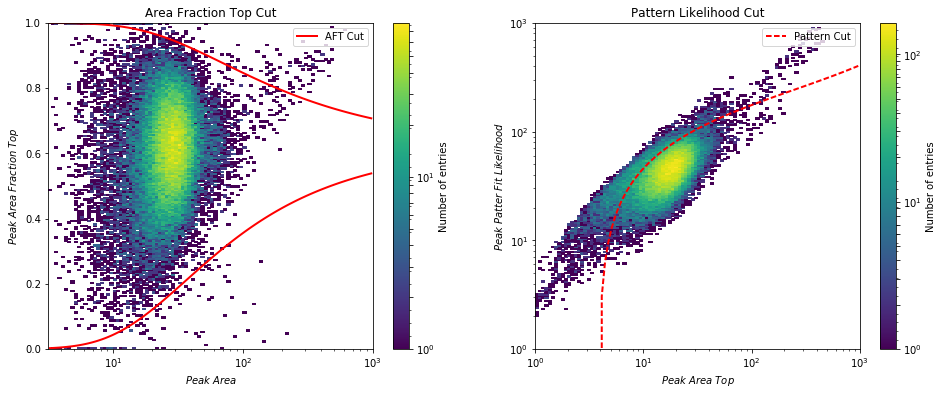

In [16]:
from scipy.stats import beta
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()

########################################################################
ax = fig.add_subplot(121)
args = ['{df}.area', '{df}.area_fraction_top']
dfs = ['df']
mha = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
             bins = [np.logspace(0.5, 3, 101), np.linspace(0, 1, 201)])
mha.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))

aft = 0.6256
x = mha.bin_centers(axis = 0)
upper_lim = np.vectorize(lambda s2:beta.ppf(1-1e-6, a=s2*0.75*aft+1, b=s2*0.75*(1-aft)+1))
lower_lim = np.vectorize(lambda s2:beta.ppf(1e-6, a=s2*0.75*aft+1, b=s2*0.75*(1-aft)+1))
plt.plot(x, upper_lim(x), 'r-', x, lower_lim(x), 'r-', lw = 2.0)

plt_config(xlabel = '$Peak\ Area$', ylabel = '$Peak\ Area\ Fraction\ Top$', title = 'Area Fraction Top Cut')
plt.xscale('log')
plt.legend(['AFT Cut'])

########################################################################
ax = fig.add_subplot(122)
args = ['{df}.area*{df}.area_fraction_top', '{df}.goodness_of_fit_tpf']
dfs = ['df']
mha = Histdd(eval(args[0].format(df = dfs[0])), eval(args[1].format(df = dfs[0])),
             bins = [np.logspace(0, 3, 101), np.logspace(0, 3, 201)])
mha.plot(log_scale = True, alpha = 1.0, cmap=plt.get_cmap('viridis'))

x = mha.bin_centers(axis = 0)
plt.plot(x, 0.1064*x+758.80*x**0.05639-819.29,'r--', lw = 2.0)
plt_config(xlabel = '$Peak\ Area\ Top$', ylabel = '$Peak\ Patter\ Fit\ Likelihood$', title = 'Pattern Likelihood Cut')
plt.legend(['Pattern Cut'])
plt.xscale('log'); plt.yscale('log')

plt.show()

In [80]:
def merge_single_file(file):
    ans = dict()
    indir = dict(elist=io_dir['indir_elist'], peak=io_dir['outdir_peak'])
    for key in ['elist', 'peak']:
        ans[key] = pd.read_pickle(os.path.join(indir[key], file))
    
    cols=['event_number', 'nearest_busy',
          'previous_busy', 'previous_event', 'previous_hev', 'previous_muon_veto_trigger',
          'flashing_time', 'flashing_width', 'inside_flash', 'nearest_flash']
    ans['peak'] = ans['peak'].merge(ans['elist'].loc[:,cols], left_on='event_number', right_on='event_number', how='left')
    return ans['peak']

def merge(flist):
    with Pool(processes=25, maxtasksperchild=50) as pool:
        list_of_df = list(tqdm(pool.imap(merge_single_file, flist, 2), total=len(flist)))
    return pd.concat(list_of_df)

flist = rnm.file_list
df = merge(flist)
df.head(5)

100%|██████████| 20/20 [00:00<00:00, 38.99it/s]


,area,area_fraction_top,delay_main_s1,delay_main_s2,event_number,global_event_number,goodness_of_fit_nn,goodness_of_fit_tpf,hit_time_mean,hit_time_mean_global,...,previous_largest_s2_time,nearest_busy,previous_busy,previous_event,previous_hev,previous_muon_veto_trigger,flashing_time,flashing_width,inside_flash,nearest_flash
0,42.065556,0.398615,-103651.75000,-110421.87500,18,7029000018,48.688507,48.440403,896946.31250,1.486863e+18,...,1.486863e+18,NaN,368395560000000000,4345745,368395560000000000,662814980,NaN,NaN,False,NaN
1,26.735098,0.883214,-422399.75000,-467857.06250,25,7029000025,50.632336,49.433949,578204.18750,1.486863e+18,...,1.486863e+18,NaN,368395560000000000,16306515,368395560000000000,1812520690,NaN,NaN,False,NaN
2,17.656677,0.752349,-275103.37500,-276723.68750,46,7029000046,51.937889,50.031906,725483.93750,1.486863e+18,...,1.486863e+18,NaN,368395560000000000,137281430,368395560000000000,4740728940,NaN,NaN,False,NaN
3,37.071873,0.481471,-533378.96875,-699115.53125,48,7029000048,40.969460,40.213699,467221.21875,1.486863e+18,...,1.486863e+18,NaN,368395560000000000,47353325,368395560000000000,5477841170,NaN,NaN,False,NaN
4,19.369272,0.699076,-413248.93750,-518172.25000,49,7029000049,27.556660,23.737814,587356.75000,1.486863e+18,...,1.486863e+18,NaN,368395560000000000,209331040,368395560000000000,5687172210,NaN,NaN,False,NaN


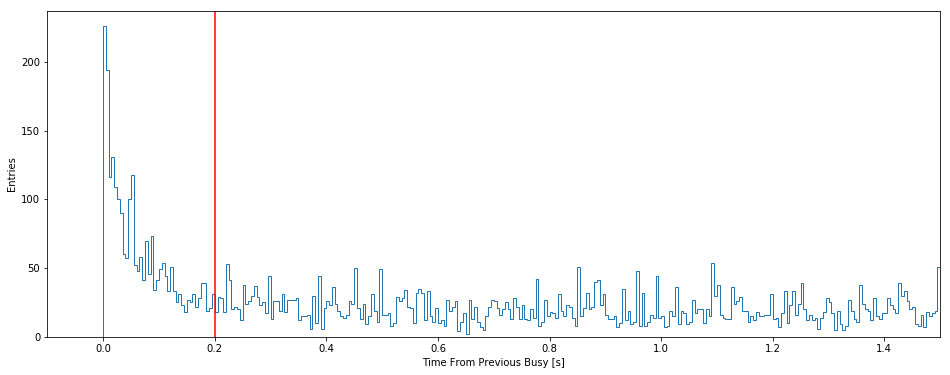

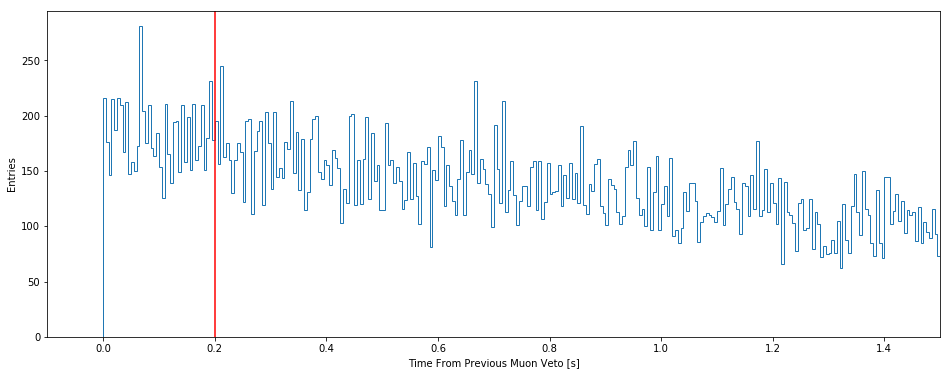

In [89]:
plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()
plt.hist(df.previous_busy/1e9, range = [0, 1.5], bins = 300, histtype = 'step')
plt.axvline(0.2, color = 'r')
plt_config(xlabel = 'Time From Previous Busy [s]', ylabel = 'Entries', xbounds = [-0.1, 1.5])
plt.show()

plt.rcParams['figure.figsize'] = (16, 6)
fig = plt.figure()
plt.hist(df.previous_muon_veto_trigger/1e9, range = [0, 1.5], bins = 300, histtype = 'step')
plt.axvline(0.2, color = 'r')

plt_config(xlabel = 'Time From Previous Muon Veto [s]', ylabel = 'Entries', xbounds = [-0.1, 1.5])
plt.show()